In [6]:
source("./preprocess/utils.R")
setwd("./")
library(mclust)
library(RColorBrewer)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "atlas_new")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "offline")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_latest")
o <- parser$parse_known_args()[[1]]

config <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$task)]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$task)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$model, o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat_cca", "l1.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

In [7]:
z_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir    <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)

    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    if (file.exists(label_paths[i])) {
        label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
    } else {
        is_label <- F
    }
    
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/34, File 1/29

Loading Subset 1/34, File 2/29

Loading Subset 1/34, File 3/29

Loading Subset 1/34, File 4/29

Loading Subset 1/34, File 5/29

Loading Subset 1/34, File 6/29

Loading Subset 1/34, File 7/29

Loading Subset 1/34, File 8/29

Loading Subset 1/34, File 9/29

Loading Subset 1/34, File 10/29

Loading Subset 1/34, File 11/29

Loading Subset 1/34, File 12/29

Loading Subset 1/34, File 13/29

Loading Subset 1/34, File 14/29

Loading Subset 1/34, File 15/29

Loading Subset 1/34, File 16/29

Loading Subset 1/34, File 17/29

Loading Subset 1/34, File 18/29

Loading Subset 1/34, File 19/29

Loading Subset 1/34, File 20/29

Loading Subset 1/34, File 21/29

Loading Subset 1/34, File 22/29

Loading Subset 1/34, File 23/29

Loading Subset 1/34, File 24/29

Loading Subset 1/34, File 25/29

Loading Subset 1/34, File 26/29

Loading Subset 1/34, File 27/29

Loading Subset 1/34, File 28/29

Loading Subset 1/34, File 29/29

Loading Subset 2/34, File 1/24

Loading Subset 2/34,

Loading Subset 3/34, File 10/40

Loading Subset 3/34, File 11/40

Loading Subset 3/34, File 12/40

Loading Subset 3/34, File 13/40

Loading Subset 3/34, File 14/40

Loading Subset 3/34, File 15/40

Loading Subset 3/34, File 16/40

Loading Subset 3/34, File 17/40

Loading Subset 3/34, File 18/40

Loading Subset 3/34, File 19/40

Loading Subset 3/34, File 20/40

Loading Subset 3/34, File 21/40

Loading Subset 3/34, File 22/40

Loading Subset 3/34, File 23/40

Loading Subset 3/34, File 24/40

Loading Subset 3/34, File 25/40

Loading Subset 3/34, File 26/40

Loading Subset 3/34, File 27/40

Loading Subset 3/34, File 28/40

Loading Subset 3/34, File 29/40

Loading Subset 3/34, File 30/40

Loading Subset 3/34, File 31/40

Loading Subset 3/34, File 32/40

Loading Subset 3/34, File 33/40

Loading Subset 3/34, File 34/40

Loading Subset 3/34, File 35/40

Loading Subset 3/34, File 36/40

Loading Subset 3/34, File 37/40

Loading Subset 3/34, File 38/40

Loading Subset 3/34, File 39/40

Loading Su

In [3]:
rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
obj <- CreateSeuratObject(counts = rna, assay = "rna")

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

u <- z[, (K+1):(K+2)]
colnames(u) <- paste0("u_", seq_len(ncol(u)))
rownames(u) <- colnames(obj)
obj[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "rna")

obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]


obj


                lll_ctrl                 lll_stim                 dig_ctrl 
                    7361                     5897                    10190 
                dig_stim                       w1                       w3 
                    9527                     7325                     6587 
                      w4                       w5                       w6 
                    6897                     6910                     7137 
            tea_multi_w1             tea_multi_w2 10x_multiome_chrom_x_10k 
                    6096                     7284                     9868 
10x_multiome_chrom_c_10k    10x_multiome_arc2_10k     10x_multiome_arc2_3k 
                    9582                    11116                     2566 
               asap_ctrl                asap_stim                cite_ctrl 
                    4255                     5241                     5086 
               cite_stim                     p1_0                     p2_0 
           

An object of class Seurat 
34 features across 252789 samples within 1 assay 
Active assay: rna (34 features, 0 variable features)
 2 dimensional reductions calculated: c, u

In [4]:
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
obj <- RunUMAP(obj, reduction = 'u', dims = 1:2, metric = "euclidean", reduction.name = 'u.umap')

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
01:25:42 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

01:25:42 Read 252789 rows and found 32 numeric columns

01:25:42 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

01:25:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:28:06 Writing NN index file to

In [8]:
obj <- AddMetaData(object = obj,     #seurat对象
                    metadata = do.call('c', label_list),    #需要添加的metadata
                    col.name = "label")

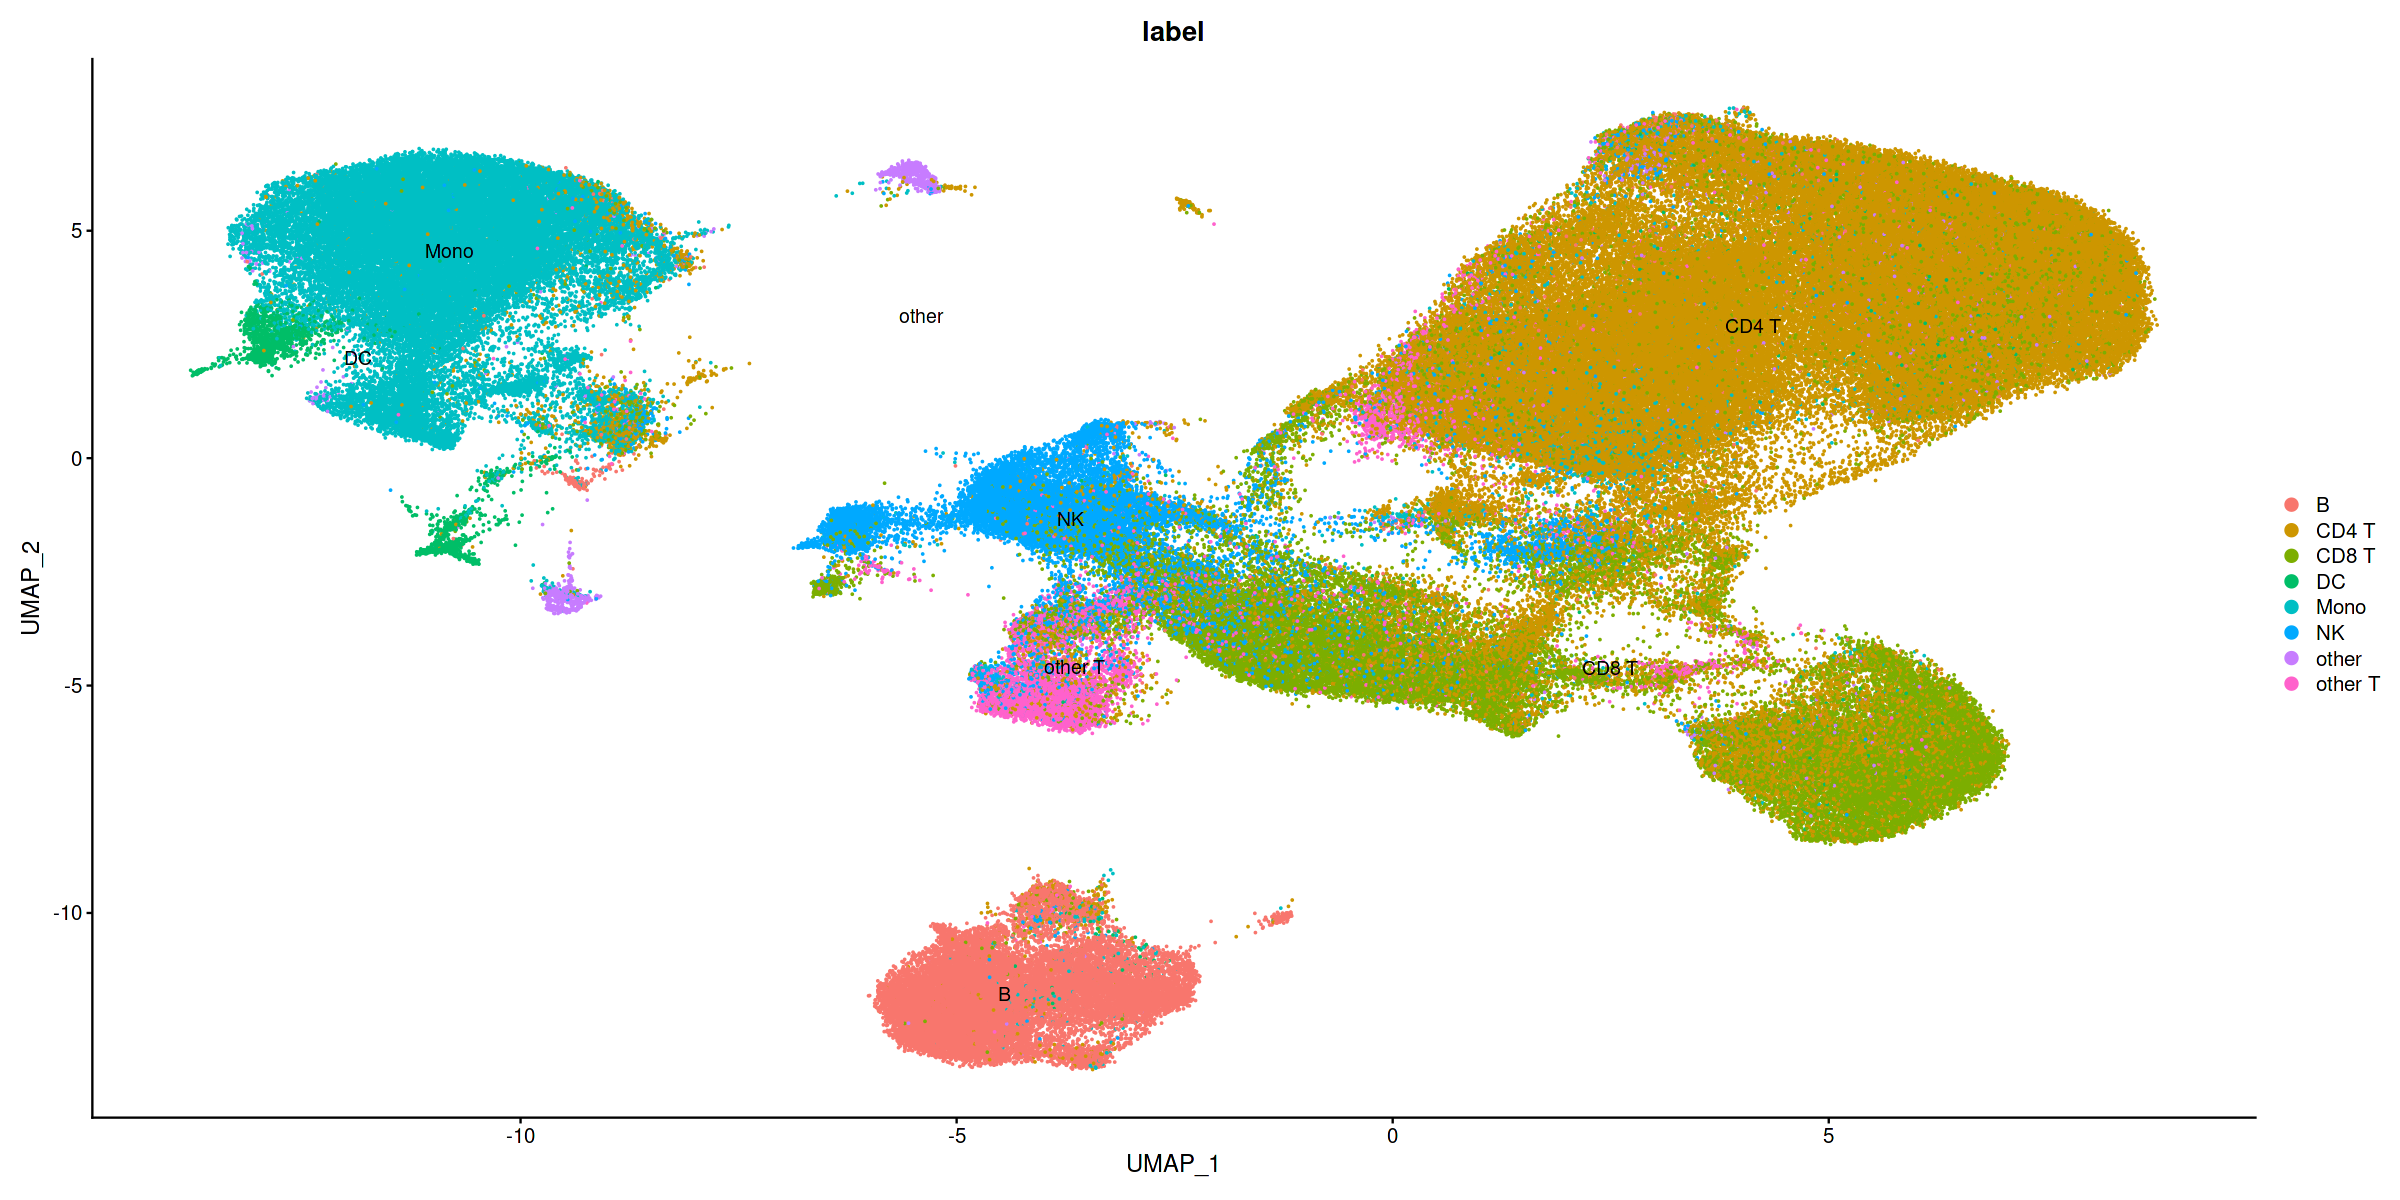

In [7]:
plt_size(w = 2*L, h = L)
DimPlot(obj, group.by = 'label', reduction = "c.umap", raster=FALSE, label = T)

In [18]:
DefaultAssay(obj) <- "rna"
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData()
obj <- FindNeighbors(obj, reduction = 'c', dims = 1:K, assay = "rna")
obj <- FindClusters(obj, graph.name = "rna_snn", algorithm = 3, resolution = 0.35)

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 252789
Number of edges: 6396064

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9434
Number of communities: 29
Elapsed time: 724 seconds


5 singletons identified. 24 final clusters.

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


In [19]:
plt_size(w = 2*L, h = L)
p1 <- DimPlot(obj, reduction = 'c.umap', group.by = "seurat_clusters", label = T, repel = T,
    label.size = 4, pt.size = 0.4, cols = col_32, raster=FALSE)

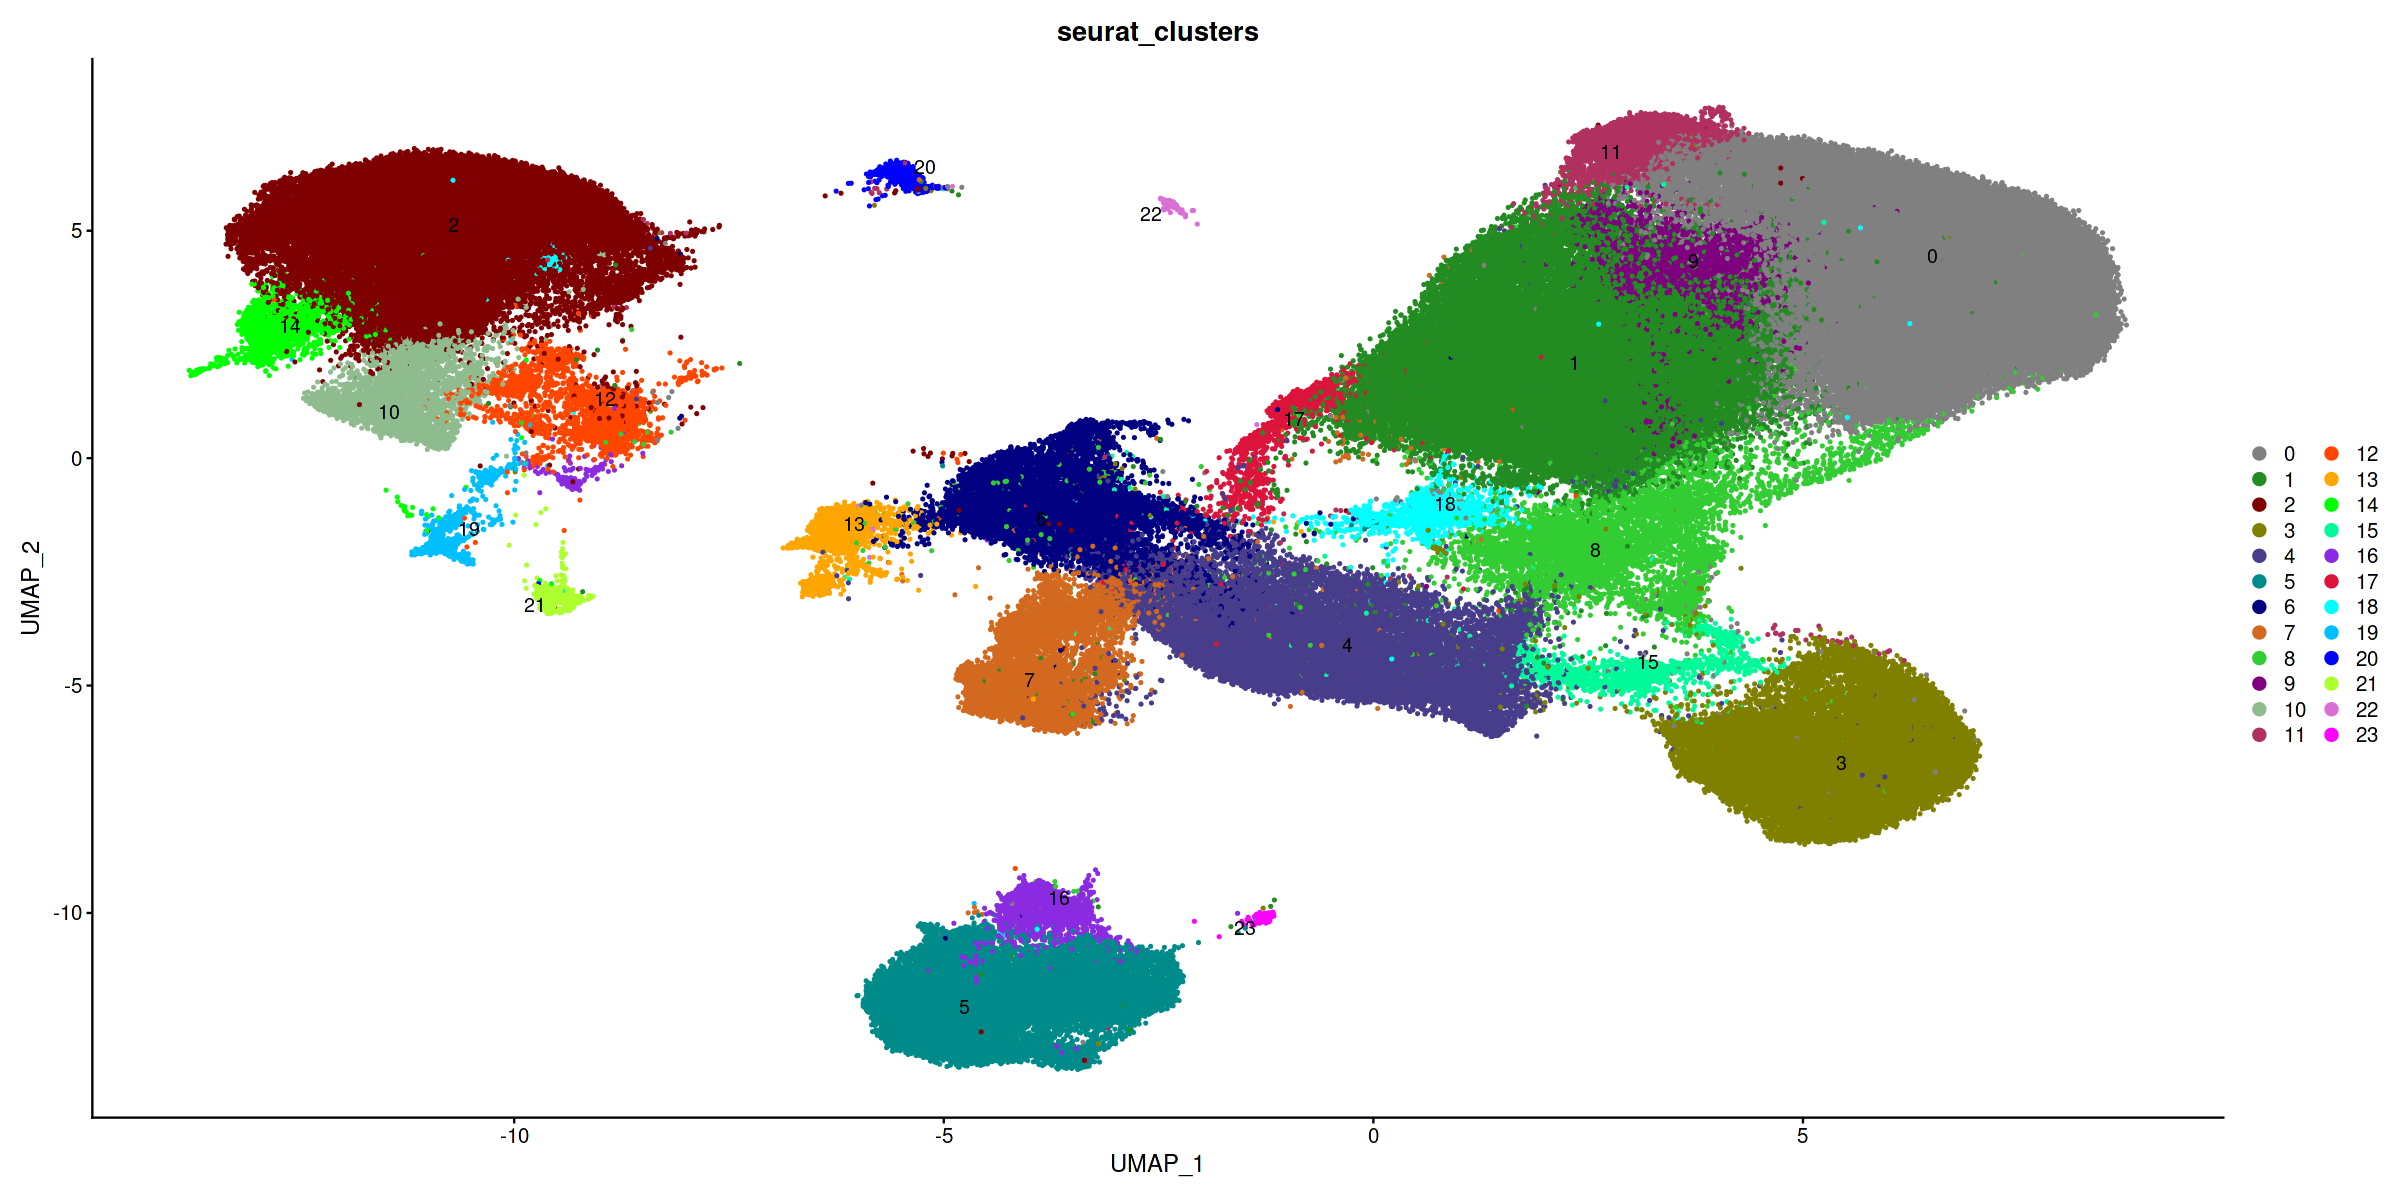

In [57]:
p1

In [61]:
x_bc_list <- list()
is_label <- T
rna_names <- read.table(pj(pp_dir, 'feat', 'feat_names_rna.csv'), sep = ",", header = T)
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    x_bc_dir    <- pj(input_dirs[i], "x_bc", "rna")
    fnames <- dir(path = x_bc_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    x_bc_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        x_bc_subset_list[[n]] <- read.csv(file.path(x_bc_dir, fnames[n]), header = F)
    }
    x_bc_list[[subset_name]] <- bind_rows(x_bc_subset_list)
}

Loading Subset 1/34, File 1/29



Loading Subset 1/34, File 2/29

Loading Subset 1/34, File 3/29

Loading Subset 1/34, File 4/29

Loading Subset 1/34, File 5/29

Loading Subset 1/34, File 6/29

Loading Subset 1/34, File 7/29

Loading Subset 1/34, File 8/29

Loading Subset 1/34, File 9/29

Loading Subset 1/34, File 10/29

Loading Subset 1/34, File 11/29

Loading Subset 1/34, File 12/29

Loading Subset 1/34, File 13/29

Loading Subset 1/34, File 14/29

Loading Subset 1/34, File 15/29

Loading Subset 1/34, File 16/29

Loading Subset 1/34, File 17/29

Loading Subset 1/34, File 18/29

Loading Subset 1/34, File 19/29

Loading Subset 1/34, File 20/29

Loading Subset 1/34, File 21/29

Loading Subset 1/34, File 22/29

Loading Subset 1/34, File 23/29

Loading Subset 1/34, File 24/29

Loading Subset 1/34, File 25/29

Loading Subset 1/34, File 26/29

Loading Subset 1/34, File 27/29

Loading Subset 1/34, File 28/29

Loading Subset 1/34, File 29/29

Loading Subset 2/34, File 1/24

Loading Subset 2/34, File 2/24

Loading Subset 2/34,

In [62]:
rna <- t(data.matrix(bind_rows(x_bc_list)))  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- rna_names[[2]]
obj_x_bc <- CreateSeuratObject(counts = rna, assay = "rna")
obj_x_bc <- AddMetaData(object = obj_x_bc,     #seurat对象
                    metadata = obj@meta.data$seurat_clusters,    #需要添加的metadata
                    col.name = "seurat_clusters")

In [63]:
Idents(obj_x_bc) <- obj_x_bc@meta.data[["seurat_clusters"]]
DefaultAssay(obj_x_bc) <- "rna" 
markers_rna <- FindAllMarkers(obj_x_bc, only.pos = T, min.pct = 0.25, logfc.threshold = 0.25)
markers_5 <- markers_rna %>% group_by(cluster) %>%  slice_max(n = 5, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"
Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23



In [65]:
markers_5

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene       
1   0             1.3206481  0.910 0.469 0             0       PLCL1      
2   0             1.1294245  0.889 0.448 0             0       FHIT       
3   0             1.0530621  0.910 0.398 0             0       TSHZ2      
4   0             1.0050404  0.983 0.831 0             0       CAMK2D     
5   0             0.9768402  0.907 0.415 0             0       LEF1       
6   0             1.4629979  0.966 0.552 0             1       ANK3       
7   0             1.1797227  0.621 0.204 0             1       TNFRSF4    
8   0             1.1458870  0.819 0.449 0             1       TSHZ2      
9   0             1.0343893  0.711 0.360 0             1       IL2RA      
10  0             1.0130587  0.635 0.183 0             1       MAF        
11  0             1.9329076  0.998 0.918 0             2       NEAT1      
12  0             1.9307616  0.861 0.063 0             2       VCAN       
13  0             1.7732199  0.948 0.243 0             2       SAT1       
14  0             1.7272924  0.936 0.282 0             2       ZEB2       
15  0             1.7067468  0.888 0.078 0             2       RBM47      
16  0             1.5887023  0.933 0.360 0             3       NELL2      
17  0             1.2596945  0.966 0.650 0             3       PSMA1      
18  0             1.0647815  0.840 0.387 0             3       THEMIS     
19  0             1.0118778  0.986 0.774 0             3       PDE3B      
20  0             0.9016488  0.626 0.071 0             3       CD8B       
21  0             1.1774302  0.825 0.228 0             4       CCL5       
22  0             0.8995421  0.789 0.363 0             4       AOAH       
23  0             0.8002905  0.991 0.886 0             4       ATXN1      
24  0             0.7888761  0.621 0.125 0             4       CD8A       
25  0             0.7410244  0.573 0.250 0             4       CCL4       
26  0             2.3667902  0.978 0.275 0             5       PALM2-AKAP2
27  0             2.3536214  0.955 0.023 0             5       EBF1       
28  0             2.3122763  0.926 0.032 0             5       IGHM       
29  0             2.2649925  0.972 0.093 0             5       IGKC       
30  0             2.2156007  0.923 0.027 0             5       BANK1      
... ...           ...        ...   ...   ...           ...     ...        
86  1.743783e-231 1.2883188  0.621 0.284 7.051859e-228 18      LTA        
87   8.472683e-72 1.2412637  0.470 0.277  3.426353e-68 18      CCL4       
88  5.527072e-105 1.1651409  0.431 0.216 2.235148e-101 18      IFNG       
89  6.396777e-189 1.1242024  0.840 0.640 2.586857e-185 18      AC016831.7 
90  3.191217e-229 1.0877392  0.757 0.420 1.290528e-225 18      IL2RA      
91   0.000000e+00 3.9426380  0.955 0.119  0.000000e+00 19      TCF4       
92   0.000000e+00 3.1809220  0.972 0.352  0.000000e+00 19      TXN        
93   0.000000e+00 3.1101777  0.999 0.705  0.000000e+00 19      FCHSD2     
94   0.000000e+00 3.0792649  0.974 0.225  0.000000e+00 19      UGCG       
95   0.000000e+00 3.0122708  1.000 0.549  0.000000e+00 19      CD74       
96   0.000000e+00 3.1712119  0.963 0.184  0.000000e+00 20      HIST1H2AC  
97   0.000000e+00 3.0987407  0.924 0.058  0.000000e+00 20      RGS18      
98   0.000000e+00 2.3962042  0.924 0.378  0.000000e+00 20      LIMS1      
99   0.000000e+00 2.3877578  0.870 0.174  0.000000e+00 20      TSC22D1    
100  0.000000e+00 2.3869055  0.998 0.904  0.000000e+00 20      TMSB4X     
101  0.000000e+00 3.0836998  0.979 0.145  0.000000e+00 21      ATP8B4     
102  0.000000e+00 2.8111980  0.937 0.205  0.000000e+00 21      ABCC4      
103  0.000000e+00 2.7782661  0.942 0.054  0.000000e+00 21      MED12L     
104  0.000000e+00 2.6189874  0.912 0.180  0.000000e+00 21      MAST4      
105  0.000000e+00 2.6054010  0.974 0.457  0.000000e+00 21      STXBP5     
106 4.305619e-116 1.0500329  0.826 0.234 1.741192e-112 22      TGFBR3     
107  3.158959e-91 0.8951790  

In [64]:
# http://xteam.xbio.top/CellMarker/
# https://panglaodb.se/search.html
new.cluster.ids <- c("CD4+ Naive T cells", "CD4+ Memory T cells", "Monocytes", "CD8+ Naive T cells", "CD8+ Memory T cells", "B cells", "NK cells", 
    "Unconventional T cells", "DP T cells", "Treg cells", "Monocytes", "CD4+ Naive T cells", "Monocytes", "NK cells", "Dendritic cells", "CD8+ Naive T cells", 
    "B cells", "CD4+ Memory T cells", "CD4+ Memory T cells", "Dendritic cells", "Platelet", "HSC", "CD4+ Memory T cells", "B cells")
names(new.cluster.ids) <- levels(obj)
obj <- RenameIdents(obj, new.cluster.ids)

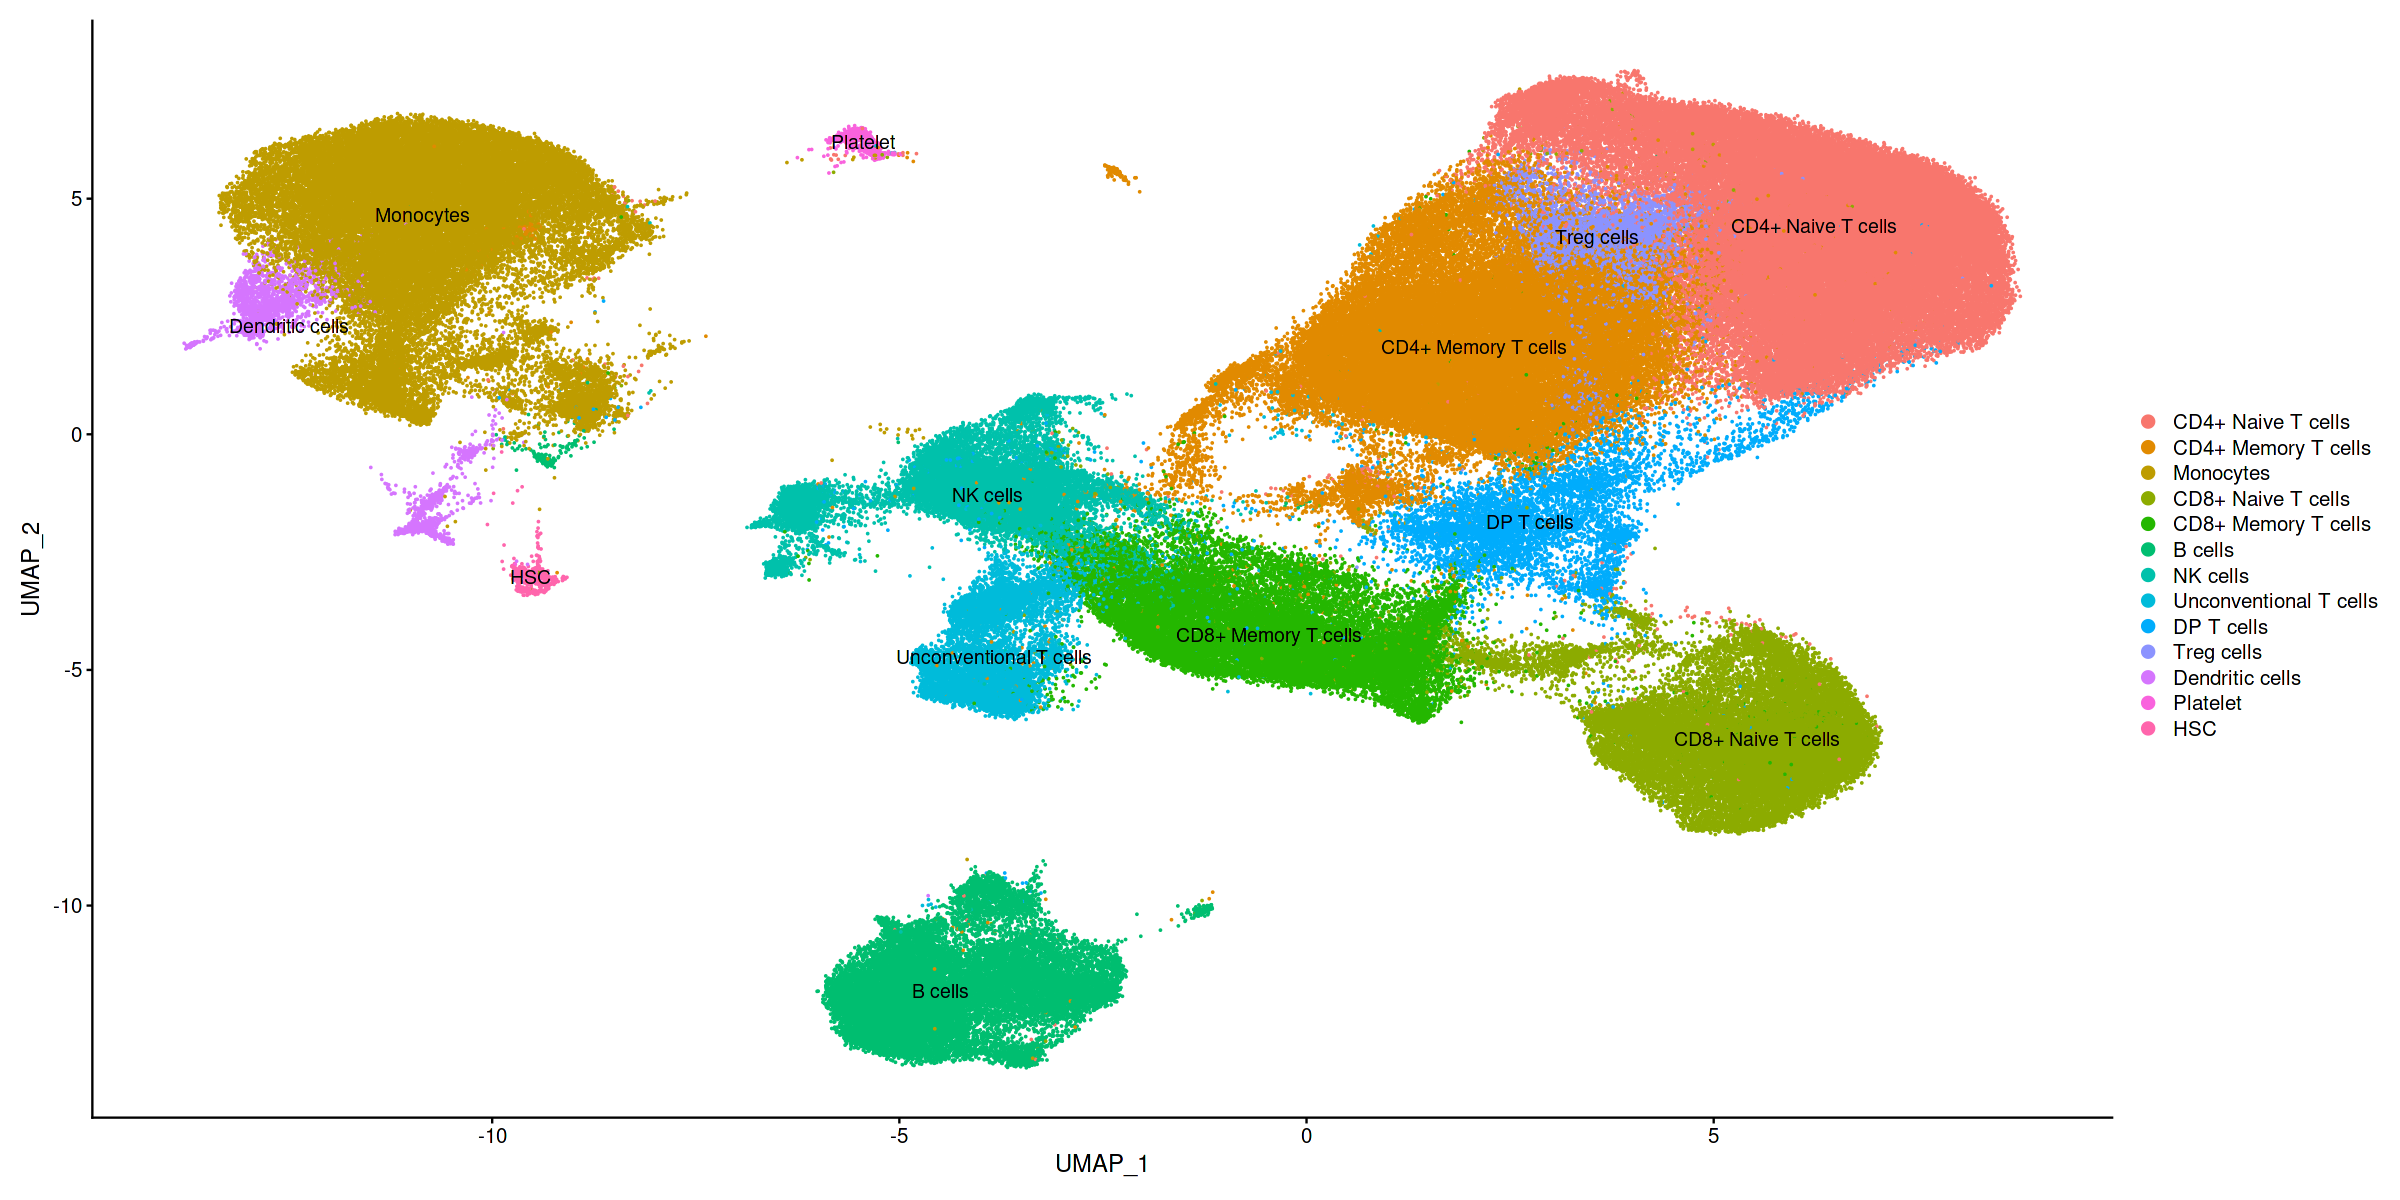

In [66]:
DimPlot(obj, reduction = "c.umap", label = TRUE, raster=FALSE)

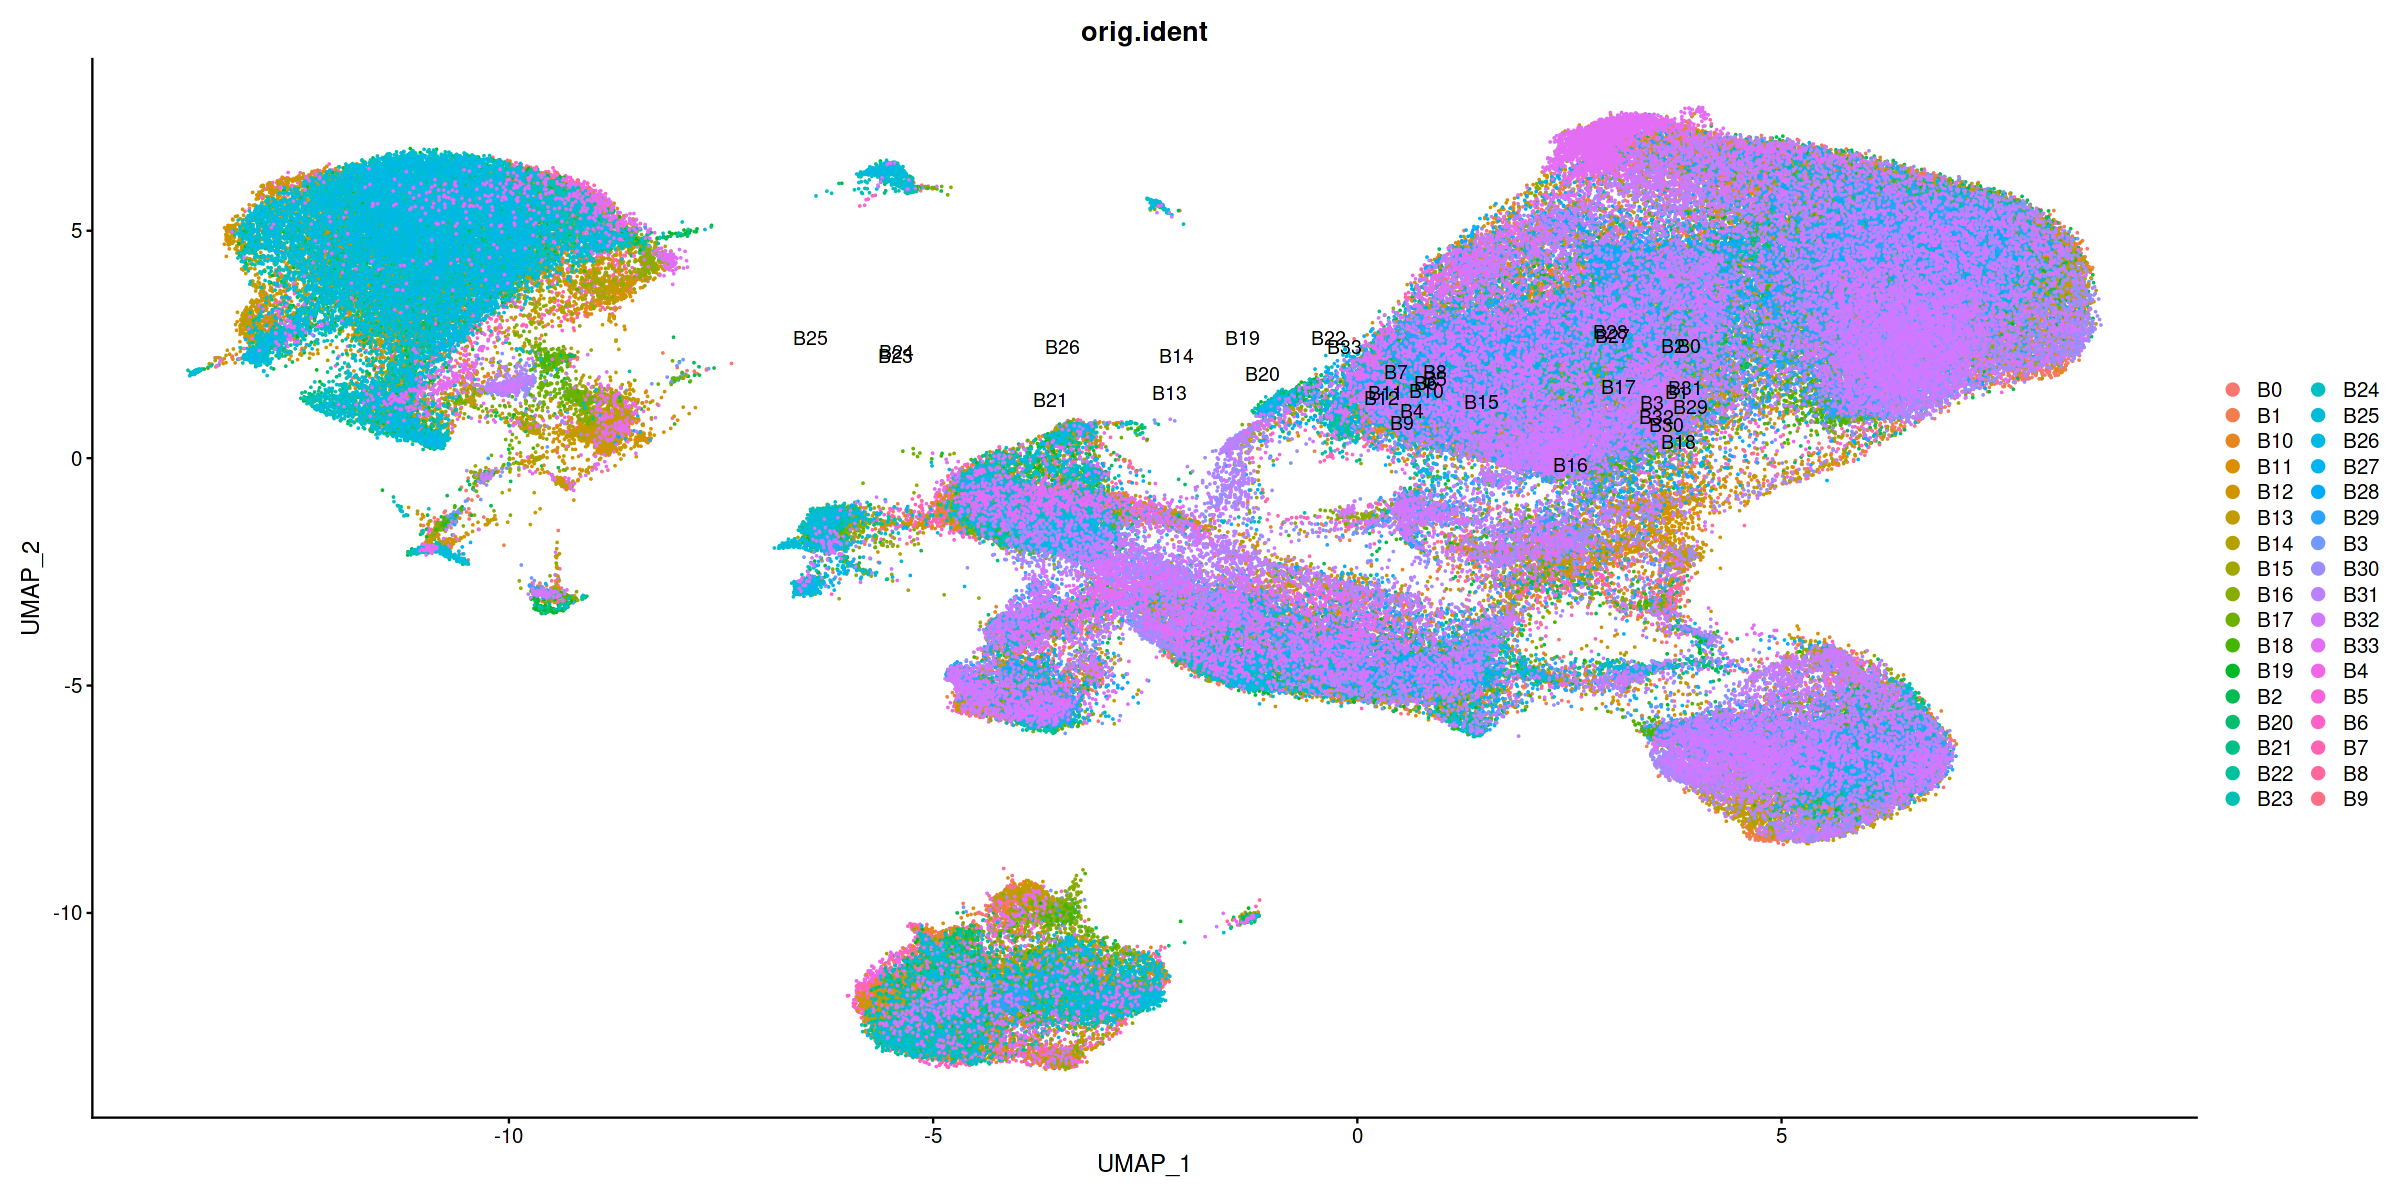

In [67]:
DimPlot(obj, group.by = 'orig.ident', label = TRUE, raster=FALSE)

In [282]:
write.csv(obj@active.ident, file = pj("atlas_new.csv"))